<div class="alert alert-block alert-info">

<h1 style="font-family:verdana;"> Description:</h1>

<ul>
<li><p style="font-family:verdana;">
In this notebook, we are going to evaluate the deployed models on Vertex AI.
</p></li>

<li><p style="font-family:verdana;">
We will get a random sample from the dataset to make inference and compare it with the true value of the total trip fare.
</p></li>
</ul>

</div>

## Index
1. []()

## Step 0: Import needed packages

In [24]:
from google.cloud import bigquery
import tensorflow as tf
import base64
from google.cloud import aiplatform
import matplotlib.pyplot as plt
import seaborn as sns

## Step 1: Set up GCP Environment variables

In [25]:
GOOGLE_CLOUD_PROJECT = 'demoespecialidadgcp'
GOOGLE_CLOUD_PROJECT_NUMBER = '502688298240'
GOOGLE_CLOUD_REGION = 'us-east1'
GCS_BUCKET_NAME = 'demo-1-chicago-taxi-fare'

## Step 2: Get sample data from BigQuery

In [26]:

QUERY = """
        SELECT 
            trip_seconds,
            trip_miles,
            trip_total,
            CASE WHEN EXTRACT(DAYOFWEEK FROM trip_start_timestamp) < 5 THEN 1 ELSE 0 END AS work_day,
            CASE WHEN EXTRACT(HOUR FROM trip_start_timestamp) BETWEEN 8 AND 18 THEN 1 ELSE 0 END AS work_hour,
            trip_miles/(trip_seconds/3600) AS trip_speed,
            pickup_community_area,
            dropoff_community_area
        FROM 
            `demoespecialidadgcp.demo_1.view_chicago_taxi_trips`
        WHERE
            trip_seconds > 0 AND trip_seconds < 7200 AND
            trip_miles > 0 AND
            trip_total > 0 AND trip_total < 250 AND
            payment_type = "Cash" AND payment_type = "Cash" AND
            trip_start_timestamp IS NOT NULL AND
            pickup_community_area IS NOT NULL AND
            dropoff_community_area IS NOT NULL AND
            RAND() < 100000/(SELECT COUNT(*) FROM `demoespecialidadgcp.demo_1.view_chicago_taxi_trips`)
        LIMIT 5000
"""

# Create a BigQuery client
client = bigquery.Client()

# Query the data and return a pandas DataFrame
df_sample = client.query(QUERY).to_dataframe()

## Step 3: Build payload of examples and make inferences

First we define some useful functions to transform the data to raw examples according to the request payload of the endpoint.

In [27]:
def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def inference(tf_examples, endpoint_id):
    # The AI Platform services require regional API endpoints.
    ENDPOINT_ID = endpoint_id
    client_options = {
        'api_endpoint': GOOGLE_CLOUD_REGION + '-aiplatform.googleapis.com'
        }
    # Initialize client that will be used to create and send requests.
    client = aiplatform.gapic.PredictionServiceClient(client_options=client_options)

    # b64_example = base64.b64encode(tf_example.SerializeToString()).decode("utf-8")

    # instances = [
    #     {"b64": b64_example}
    # ]
    instances = [
        {"b64": base64.b64encode(tf_examples[i]["raw_example"].SerializeToString()).decode("utf-8")} for i in range(len(tf_examples))
    ]

    endpoint = client.endpoint_path(
        project=GOOGLE_CLOUD_PROJECT,
        location=GOOGLE_CLOUD_REGION,
        endpoint=ENDPOINT_ID,
    )
    # Send a prediction request and get response.
    return client.predict(endpoint=endpoint, instances=instances)

    

Build the raw examples.

In [28]:
tf_examples: list[dict] = []
for i in range(len(df_sample)):
    raw_example = df_sample.iloc[i].to_dict()

    feature_dict = {}
    feature_dict["trip_seconds"] = _int_feature(int(raw_example["trip_seconds"]))
    feature_dict["trip_miles"] = _float_feature(raw_example["trip_miles"])
    feature_dict["work_day"] = _int_feature(int(raw_example["work_day"]))
    feature_dict["work_hour"] = _int_feature(int(raw_example["work_hour"]))
    feature_dict["trip_speed"] = _float_feature(raw_example["trip_speed"])
    feature_dict["pickup_community_area"] = _int_feature(int(raw_example["pickup_community_area"]))
    feature_dict["dropoff_community_area"] = _int_feature(int(raw_example["dropoff_community_area"]))
    feature_dict["trip_total"] = _float_feature(raw_example["trip_total"])


    tf_example = tf.train.Example(features=tf.train.Features(feature = feature_dict))
    tf_examples.append({"raw_example": tf_example, "true_value": raw_example["trip_total"]})

Make inferences for each one of the deployed models.

In [29]:
inference_response_1 = inference(tf_examples, 8719008461007880192)
inference_response_2 = inference(tf_examples, 6124935075642474496)
inference_response_3 = inference(tf_examples, 3819092066428780544)

## Step 4: Model performance analysis

Get the predictions and residuals into lists.

In [43]:
true_values = [tf_examples[i]["true_value"] for i in range(len(tf_examples))]
model_1_inference = [inference_response_1.predictions[i][0] for i in range(len(tf_examples))]
model_2_inference = [inference_response_2.predictions[i][0] for i in range(len(tf_examples))]
model_3_inference = [inference_response_3.predictions[i][0] for i in range(len(tf_examples))]

residuals_model_1 = [true_values[i] - model_1_inference[i] for i in range(len(tf_examples))]
residuals_model_2 = [true_values[i] - model_2_inference[i] for i in range(len(tf_examples))]
residuals_model_3 = [true_values[i] - model_3_inference[i] for i in range(len(tf_examples))]

MAE for each model.

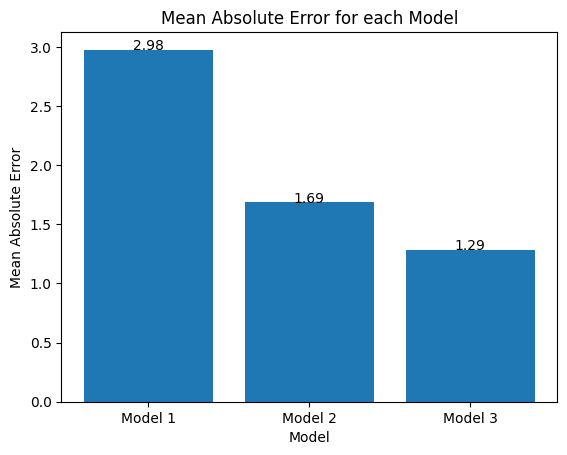

In [68]:
# Plot the MAE for each model
mae_1 = sum([abs(inference_response_1.predictions[i][0] - tf_examples[i]["true_value"]) for i in range(len(tf_examples))])/len(tf_examples)
mae_2 = sum([abs(inference_response_2.predictions[i][0] - tf_examples[i]["true_value"]) for i in range(len(tf_examples))])/len(tf_examples)
mae_3 = sum([abs(inference_response_3.predictions[i][0] - tf_examples[i]["true_value"]) for i in range(len(tf_examples))])/len(tf_examples)
plt.bar(["Model 1", "Model 2", "Model 3"], [mae_1, mae_2, mae_3])
# Add the value of the MAE to the plot
for i in range(3):
    plt.text(i, [mae_1, mae_2, mae_3][i], round([mae_1, mae_2, mae_3][i], 2), ha = 'center')
    
plt.xlabel("Model")
plt.ylabel("Mean Absolute Error")
plt.title("Mean Absolute Error for each Model")
plt.show()

It is clear that the Model 3 is the best performant model with a $MAE=1.29$. Meaning that, in average, the model will predict a Total Fare which can be 1.29 USD cheaper or expensive than the true Total Fare. 

Scatter plot of the true trip total fare value and the predicted ones.

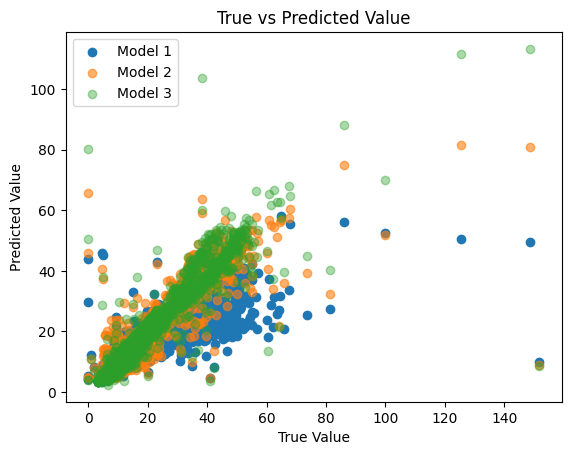

In [41]:
plt.scatter(true_values, model_1_inference, alpha=1.)
plt.scatter(true_values, model_2_inference, alpha=0.6)
plt.scatter(true_values, model_3_inference, alpha=0.4)
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.title("True vs Predicted Value")
plt.legend(["Model 1", "Model 2", "Model 3"])
plt.show()

As the first insight gained at analysing the MAE, this scatter plot of the predicted fare versus the true fare, gives more robustness to assert that the Model 3 is the most performant because it has a clear linear relationship with the true values. Nevertheless, there are some predictions that could be considered as anomlaies, this will be discussed later.

Scatter plot of the residuals.

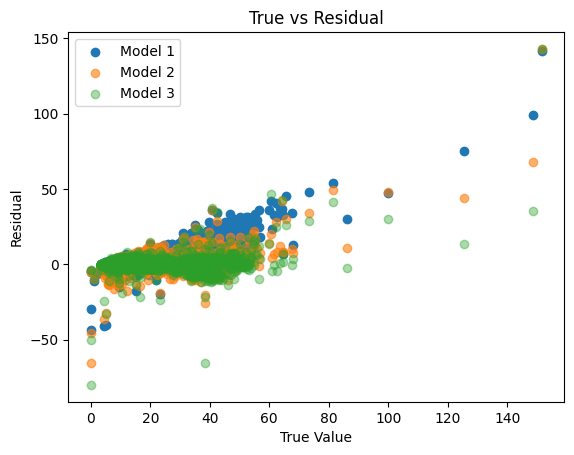

In [44]:
# plot the residuals
plt.scatter(true_values, residuals_model_1, alpha=1.)
plt.scatter(true_values, residuals_model_2, alpha=0.6)
plt.scatter(true_values, residuals_model_3, alpha=0.4)
plt.xlabel("True Value")
plt.ylabel("Residual")
plt.title("True vs Residual")
plt.legend(["Model 1", "Model 2", "Model 3"])
plt.show()

As expected, the residuals of Model 3 are mostly narrowed around 0, meaning that the error of each prediction is closer to 0. Meanwhile the Model 1 is clearly the worst performant.

Distribution of the residuals

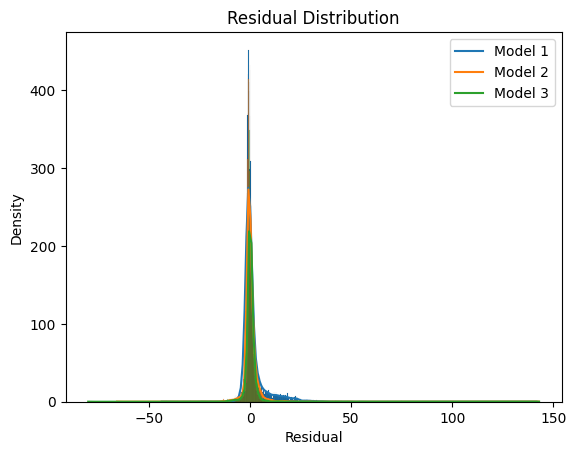

In [45]:
# plot the distribution of residuals with kde and sns
sns.histplot(residuals_model_1, kde=True, alpha=1.)
sns.histplot(residuals_model_2, kde=True, alpha=0.6)
sns.histplot(residuals_model_3, kde=True, alpha=0.4)
plt.xlabel("Residual")
plt.ylabel("Density")
plt.title("Residual Distribution")
plt.legend(["Model 1", "Model 2", "Model 3"])
plt.show()

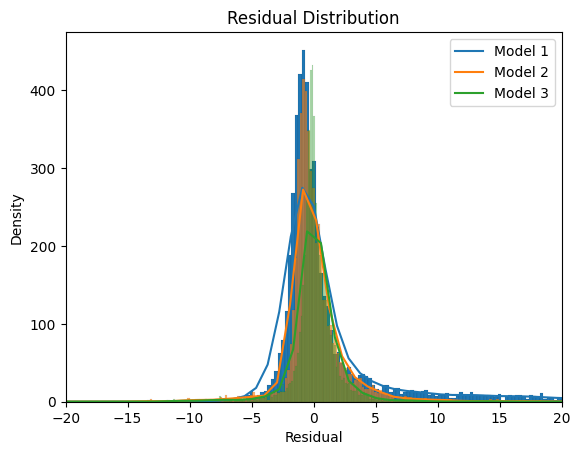

In [76]:
# plot the distribution of residuals with kde and sns
sns.histplot(residuals_model_1, kde=True, alpha=1.)
sns.histplot(residuals_model_2, kde=True, alpha=0.6)
sns.histplot(residuals_model_3, kde=True, alpha=0.4)
plt.xlabel("Residual")
plt.ylabel("Density")
plt.title("Residual Distribution")
plt.legend(["Model 1", "Model 2", "Model 3"])
plt.xlim(-20,20)
plt.show()

As discused in the Scatter plot of the residuals, the distribution of the residuals gives more insights given that the Model 3 has the narrowest distribution around 0. 

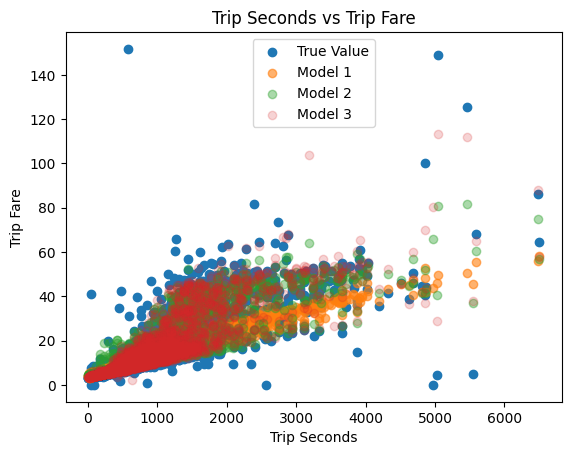

In [66]:
# Plot true trip_total as function of trip_seconds and the predicted value vs trip_seconds
plt.scatter([tf_examples[i]["raw_example"].features.feature["trip_seconds"].int64_list.value[0] for i in range(len(tf_examples))], [tf_examples[i]["true_value"] for i in range(len(tf_examples))], alpha=1.)
plt.scatter([tf_examples[i]["raw_example"].features.feature["trip_seconds"].int64_list.value[0] for i in range(len(tf_examples))], [inference_response_1.predictions[i][0] for i in range(len(tf_examples))], alpha=0.6)
plt.scatter([tf_examples[i]["raw_example"].features.feature["trip_seconds"].int64_list.value[0] for i in range(len(tf_examples))], [inference_response_2.predictions[i][0] for i in range(len(tf_examples))], alpha=0.4)
plt.scatter([tf_examples[i]["raw_example"].features.feature["trip_seconds"].int64_list.value[0] for i in range(len(tf_examples))], [inference_response_3.predictions[i][0] for i in range(len(tf_examples))], alpha=0.2)
plt.xlabel("Trip Seconds")
plt.ylabel("Trip Fare")
plt.title("Trip Seconds vs Trip Fare")
plt.legend(["True Value", "Model 1", "Model 2", "Model 3"])
plt.show()

It is important to compare the true and predicted Trip Fares as function of Trip Seconds, because we can see that there are anomalies where trips that lasted more than 1h have cheaper trip fares which is not consistent with the business because the Fare increases over time. On the other hand, the there are some Taxi Trips which lasted less than 30min and are more expensive than the average fare of the same time-lasting trips. 

This can be seen more clearly in the Scatter plot of the predicted values versus true values, the ones with higher error corresponds to anomalous trips.